In [1]:
import json
from dataclasses import asdict, is_dataclass
from pathlib import Path
import sys
import pandas as pd

# Base path for data
BASE = Path.cwd()

# Load datasets
pool_cfg = pd.read_csv(BASE / 'dune_pipeline' / 'pool_config_eth_usdt_0p3.csv')
slot0 = pd.read_csv(BASE / 'dune_pipeline' / 'slot0_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
swaps = pd.read_csv(BASE / 'dune_pipeline' / 'swaps_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
mints = pd.read_csv(BASE / 'dune_pipeline' / 'mints_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
burns = pd.read_csv(BASE / 'dune_pipeline' / 'burns_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
tokens = pd.read_csv(BASE / 'dune_pipeline' / 'token_metadata_eth_usdt_0p3.csv')
ethusdt = pd.read_csv(BASE / 'research' / 'simulation_2' / 'ETHUSDT_hourly_data_20241101_20251101.csv')

# Import the simulator
sys.path.append(str(BASE / 'research' / 'simulation_3'))
from fee_simulator import UniswapV3FeeSimulator

sim = UniswapV3FeeSimulator(
    pool_cfg=pool_cfg,
    tokens=tokens,
    slot0=slot0,
    swaps=swaps,
    mints=mints,
    burns=burns,
    eth_usdt_prices=ethusdt,
)

# Parameters (edit here)
PRICE_LOWER = 4200.0
PRICE_UPPER = 4400.0
T_START_ISO = '2025-09-01T00:00:00Z'
T_END_ISO = '2025-09-30T06:00:00Z'
TOTAL_USD_BUDGET = 1000.0
REBALANCE_FEE_USD = 10.0

result = sim.simulate(
    price_lower=PRICE_LOWER,
    price_upper=PRICE_UPPER,
    start=T_START_ISO,
    end=T_END_ISO,
    total_usd=TOTAL_USD_BUDGET,
    validate=False,
    use_swap_liquidity=False,
    accounting_mode='growth',
    protocol_fee_encoding='base256',
)

# Normalize to dict for downstream convenience
res_dict = result.to_dict() if hasattr(result, 'to_dict') else (asdict(result) if is_dataclass(result) else result)
print(json.dumps(res_dict, indent=2))


{
  "pool": "0x4e68ccd3e89f51c3074ca5072bbac773960dfa36",
  "fee_bps": 3000,
  "tokens": {
    "token0": {
      "address": "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",
      "symbol": "WETH",
      "decimals": 18
    },
    "token1": {
      "address": "0xdac17f958d2ee523a2206206994597c13d831ec7",
      "symbol": "USDT",
      "decimals": 6
    }
  },
  "window_utc": {
    "start": "2025-09-01T00:00:00+00:00",
    "end": "2025-09-30T06:00:00+00:00"
  },
  "position_ticks": {
    "lower": -192900,
    "upper": -192420
  },
  "price": {
    "start": 4385.383153638338,
    "end": 4183.510609839919
  },
  "start_tokens": {
    "token0_amount": 0.016462107631523237,
    "token1_amount": 927.807351,
    "token0_usd": 72.37549158091561,
    "token1_usd": 927.807351,
    "total_usd": 1000.1828425809157
  },
  "start_principal_tokens": {
    "token0_amount": 0.016462107631523237,
    "token1_amount": 927.80735,
    "token0_usd": 72.3754915809156,
    "token1_usd": 927.80735,
    "total_usd": 

In [2]:
import pandas as pd
from IPython.display import display

# Destructure and present concise tables
pool = res_dict['pool']
fee_bps = res_dict['fee_bps']
sym0 = res_dict['tokens']['token0']['symbol']
sym1 = res_dict['tokens']['token1']['symbol']
win_start = res_dict['window_utc']['start']
win_end = res_dict['window_utc']['end']
lower_tick = res_dict['position_ticks']['lower']
upper_tick = res_dict['position_ticks']['upper']
price_start = res_dict['price']['start']
price_end = res_dict['price']['end']

amount_rows = []
for stage in ['start_tokens', 'start_principal_tokens', 'end_tokens', 'end_principal_tokens']:
    a = res_dict[stage]
    amount_rows.append({
        'stage': stage.replace('_tokens', ''),
        'token0_amount': a['token0_amount'],
        'token1_amount': a['token1_amount'],
        'token0_usd': a['token0_usd'],
        'token1_usd': a['token1_usd'],
        'total_usd': a['total_usd'],
    })
amounts_df = pd.DataFrame(amount_rows).set_index('stage')

fees_df = pd.DataFrame([
    {'token': sym0, 'usd': res_dict['fees_usd']['token0']},
    {'token': sym1, 'usd': res_dict['fees_usd']['token1']},
]).set_index('token')

il_usd = res_dict['impermanent_loss']['usd']
il_pct = res_dict['impermanent_loss']['pct']

print(f"Pool: {pool} | Fee: {fee_bps} bps | Pair: {sym0}/{sym1}")
print(f"Window: {win_start} → {win_end}")
print(f"Position ticks: [{lower_tick}, {upper_tick}] | Price start/end: {price_start:.4f} → {price_end:.4f}")
print("\nToken amounts (human units and USD):")
display(amounts_df)
print("\nFees (USD):")
display(fees_df)
print(f"\nImpermanent Loss: usd={il_usd:.6f}, pct={il_pct:.6%}")


Pool: 0x4e68ccd3e89f51c3074ca5072bbac773960dfa36 | Fee: 3000 bps | Pair: WETH/USDT
Window: 2025-09-01T00:00:00+00:00 → 2025-09-30T06:00:00+00:00
Position ticks: [-192900, -192420] | Price start/end: 4385.3832 → 4183.5106

Token amounts (human units and USD):


,token0_amount,token1_amount,token0_usd,token1_usd,total_usd
stage,,,,,
start,0.016462,927.807351,72.375492,927.807351,1000.182843
start_principal,0.016462,927.807350,72.375492,927.807350,1000.182842
end,0.238844,27.449737,1000.692818,27.449737,1028.142555
end_principal,0.232649,0.000000,974.736564,0.000000,974.736564



Fees (USD):


,usd
token,
WETH,25.956254
USDT,27.449737



Impermanent Loss: usd=-23.387123, pct=-2.346510%


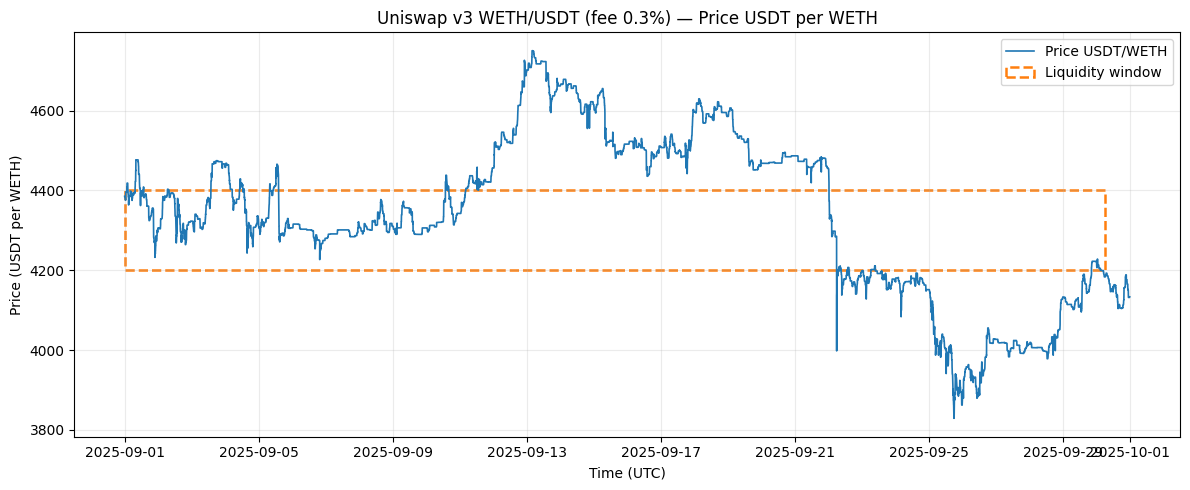

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num

# Price visualization with position window
Q96 = 2 ** 96
swaps_plot = swaps.copy()
swaps_plot['evt_block_time'] = pd.to_datetime(swaps_plot['evt_block_time'], utc=True)
swaps_plot = swaps_plot.sort_values('evt_block_time').reset_index(drop=True)

# Resolve token symbols/decimals
pool_address = pool_cfg.loc[0, 'pool']
token0_addr = pool_cfg.loc[0, 'token0'].lower()
token1_addr = pool_cfg.loc[0, 'token1'].lower()

tokens_df = tokens.copy()
tokens_df['contract_address'] = tokens_df['contract_address'].str.lower()
addr_to_decimals = dict(zip(tokens_df['contract_address'], tokens_df['decimals']))
addr_to_symbol = dict(zip(tokens_df['contract_address'], tokens_df['symbol']))

decimals0 = int(addr_to_decimals[token0_addr])
decimals1 = int(addr_to_decimals[token1_addr])
symbol0 = addr_to_symbol[token0_addr]
symbol1 = addr_to_symbol[token1_addr]

sqrt_x96 = swaps_plot['sqrtPriceX96'].astype('float64')
price_1_per_0 = (sqrt_x96 / Q96) ** 2 * (10 ** (decimals0 - decimals1))
ts = swaps_plot['evt_block_time']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts, price_1_per_0, color='#1f77b4', linewidth=1.2, label=f'Price {symbol1}/{symbol0}')

x0 = date2num(pd.to_datetime(T_START_ISO, utc=True))
x1 = date2num(pd.to_datetime(T_END_ISO, utc=True))
w = x1 - x0
rect = Rectangle((x0, PRICE_LOWER), w, (PRICE_UPPER - PRICE_LOWER),
                 fill=False, edgecolor='#ff7f0e', linewidth=1.8, linestyle='--', label='Liquidity window')
ax.add_patch(rect)

ax.set_title(f'Uniswap v3 {symbol0}/{symbol1} (fee 0.3%) — Price {symbol1} per {symbol0}')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel(f'Price ({symbol1} per {symbol0})')
ax.grid(True, alpha=0.25)
ax.legend(loc='best')
plt.tight_layout()
plt.show()


# **The Adaptive Range (Volatility-Based) Strategy**
This model dynamically adjusts its liquidity price range by scaling the width based on recent market volatility. The position is automatically re-centered and its range recalculated either when the price moves out-of-range or upon reaching a set time interval, aiming to maximize fee capture net of transaction costs.

In [4]:
strategy_summary, position_history = sim.run_rebalancing_strategy_by_time_step(
    start_time_iso=T_START_ISO,
    end_time_iso=T_END_ISO,
    total_usd_budget=TOTAL_USD_BUDGET,
    rebalance_fee_usd=REBALANCE_FEE_USD,
    time_step_hours=1,
    volatility_lookback_hours=24,
    base_tick_width=100,
    volatility_multiplier=1.5
)

In [5]:
print(strategy_summary)

{'total_fees_earned_usd': 372.1828150645753, 'total_rebalances': 68, 'total_rebalance_cost_usd': 680.0, 'net_strategy_gain_usd': -307.8171849354247}


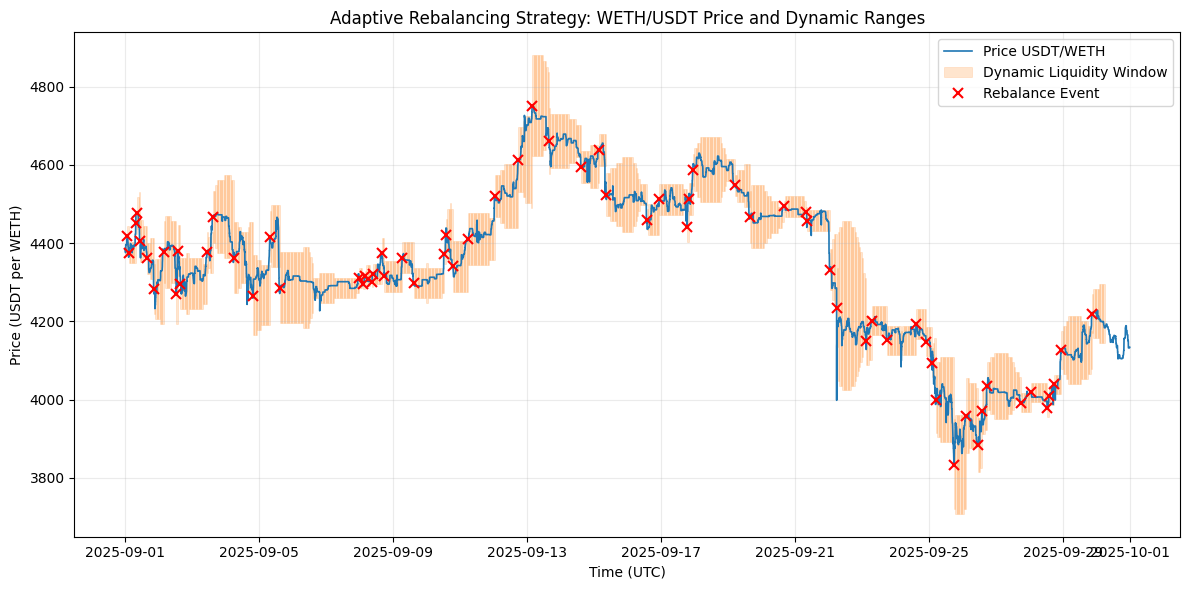

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num

# --- STEP 1: Run the Strategy and Collect History (Ensure this cell has already run) ---
# Example:
# REBALANCE_FEE_USD = 10.0
# strategy_summary, position_history = sim.run_rebalancing_strategy_by_time_step(
#     start_time_iso=T_START_ISO,
#     end_time_iso=T_END_ISO,
#     total_usd_budget=1000,
#     rebalance_fee_usd=REBALANCE_FEE_USD,
#     time_step_hours=6,
#     volatility_lookback_hours=24,
#     base_tick_width=100,
#     volatility_multiplier=1.5
# )


# --- STEP 2: Prepare Price Data (Use variables from your environment) ---

# Assuming 'swaps', 'pool_cfg', and 'tokens' DataFrames are loaded.
Q96 = 2 ** 96
swaps_plot = swaps.copy()
swaps_plot['evt_block_time'] = pd.to_datetime(swaps_plot['evt_block_time'], utc=True)
swaps_plot = swaps_plot.sort_values('evt_block_time').reset_index(drop=True)

# Resolve token symbols/decimals using the simulator's config logic
token0_addr = pool_cfg.loc[0, 'token0'].lower()
token1_addr = pool_cfg.loc[0, 'token1'].lower()
tokens_df = tokens.copy()
tokens_df['contract_address'] = tokens_df['contract_address'].str.lower()
addr_to_decimals = dict(zip(tokens_df['contract_address'], tokens_df['decimals']))
addr_to_symbol = dict(zip(tokens_df['contract_address'], tokens_df['symbol']))
decimals0 = int(addr_to_decimals[token0_addr])
decimals1 = int(addr_to_decimals[token1_addr])
symbol0 = addr_to_symbol[token0_addr]
symbol1 = addr_to_symbol[token1_addr]

sqrt_x96 = swaps_plot['sqrtPriceX96'].astype('float64')
# Calculate the price (Token1 per Token0)
price_1_per_0 = (sqrt_x96 / Q96) ** 2 * (10 ** (decimals0 - decimals1))
ts = swaps_plot['evt_block_time']

# --- STEP 3: Plot the Dynamic Windows ---

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the core price line
ax.plot(ts, price_1_per_0, color='#1f77b4', linewidth=1.2, label=f'Price {symbol1}/{symbol0}')

# Flags to ensure we only add one legend entry per plot element type
legend_window_added = False
legend_rebalance_added = False

# Loop through the position history to plot each segment
for i, pos in enumerate(position_history):
    # Convert datetime objects to numerical format for plotting (matplotlib dates)
    x0 = date2num(pos['start'])
    x1 = date2num(pos['end'])
    w = x1 - x0

    # Define the range height and lower bound
    y0 = pos['price_lower']
    h = pos['price_upper'] - pos['price_lower']

    # 1. Plot the Liquidity Window (Rectangle)
    rect_label = 'Dynamic Liquidity Window' if not legend_window_added else None

    rect = Rectangle((x0, y0), w, h,
                     fill=True,
                     alpha=0.2, # Transparent fill
                     color='#ff7f0e', # Orange color
                     linestyle='-',
                     linewidth=0.5,
                     label=rect_label,
                     zorder=1) # Ensure price line (zorder 2) is on top
    ax.add_patch(rect)
    legend_window_added = True

    # 2. Plot the Rebalance Point (X-Marker)
    if pos['rebalance'] and i > 0:
        # Find the final price in the segment that triggered the rebalance
        end_time_price_row = swaps_plot[(swaps_plot['evt_block_time'] <= pos['end'])]
        if not end_time_price_row.empty:
            end_time_price_row = end_time_price_row.iloc[-1]
            rebalance_price = float((float(end_time_price_row['sqrtPriceX96']) / Q96) ** 2 * (10 ** (decimals0 - decimals1)))

            rebalance_label = 'Rebalance Event' if not legend_rebalance_added else None

            # Plot an X at the rebalance time and price
            ax.plot(date2num(pos['end']),
                    rebalance_price,
                    marker='x',
                    markersize=7,
                    markeredgewidth=1.5,
                    color='red',
                    linestyle='',
                    label=rebalance_label,
                    zorder=5) # Ensure it's clearly visible
            legend_rebalance_added = True


# Final chart settings
ax.set_title(f'Adaptive Rebalancing Strategy: {symbol0}/{symbol1} Price and Dynamic Ranges')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel(f'Price ({symbol1} per {symbol0})')
ax.grid(True, alpha=0.25)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

# **Simple Predictive ML Strategy**
This model forecast the expected minimum and maximum price over the next $24$ hours, this strategy places liquidity proactively where the price is anticipated to trade. This predictive approach is expected to significantly reduce out-of-range events and rebalancing costs, leading to higher net fee earnings than the previous reactive or purely volatility-based strategies.

In [7]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
from decimal import Decimal

# --- CONFIGURATION (Based on your pool) ---
D0 = 18
D1 = 6
Q96 = 2**96

def get_price_float(sqrtPriceX96, decimals0=D0, decimals1=D1):
    return (float(sqrtPriceX96) / Q96) ** 2 * (10 ** (decimals0 - decimals1))

try:
    # --- Data Preparation ---
    if not isinstance(swaps, pd.DataFrame) or swaps.empty:
        raise NameError("The 'swaps' DataFrame is not defined or is empty.")

    swaps_data = swaps.copy()
    swaps_data['price'] = swaps_data['sqrtPriceX96'].apply(lambda x: get_price_float(x, D0, D1))
    swaps_data['evt_block_time'] = pd.to_datetime(swaps_data['evt_block_time'], utc=True)
    swaps_data = swaps_data.sort_values('evt_block_time').set_index('evt_block_time')

    # Resample and Calculate Features (1H resolution)
    df_features = swaps_data['price'].resample('1H').last().ffill()
    df_features = pd.DataFrame(df_features, columns=['price'])
    df_features['log_ret_1h'] = np.log(df_features['price']).diff(1)
    df_features['vol_24h'] = df_features['log_ret_1h'].rolling(window=24).std()
    df_features = df_features.dropna()

    # Create Targets (Min/Max Price in Next 24 Hours)
    targets = []
    for index in df_features.index:
        start_time = index
        end_time = index + timedelta(hours=24)
        future_prices = swaps_data['price'].loc[start_time:end_time]

        if not future_prices.empty and future_prices.index.max() > index:
            targets.append({
                'min_price_24h': future_prices.min(),
                'max_price_24h': future_prices.max(),
                'time': index
            })
        else:
             targets.append({'min_price_24h': np.nan, 'max_price_24h': np.nan, 'time': index})

    df_targets = pd.DataFrame(targets).set_index('time')
    df_model = df_features.join(df_targets, how='inner').dropna()

    X = df_model[['price', 'log_ret_1h', 'vol_24h']]
    Y_min = df_model['min_price_24h']
    Y_max = df_model['max_price_24h']

    # Train-test split
    split_point = int(len(X) * 0.5)
    X_train = X.iloc[:split_point]
    Y_min_train = Y_min.iloc[:split_point]
    Y_max_train = Y_max.iloc[:split_point]

    # Model Training
    model_min = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    model_min.fit(X_train, Y_min_train)

    model_max = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    model_max.fit(X_train, Y_max_train)

    # Save Models
    trained_models = {'model_min': model_min, 'model_max': model_max, 'D0': D0, 'D1': D1}
    with open('predictive_models.pkl', 'wb') as f:
        pickle.dump(trained_models, f)

    print("--- Machine Learning Model Training Complete ---")
    print(f"Dataset size (1H intervals): {len(df_model)}")
    print("Trained models saved to 'predictive_models.pkl'.")

except NameError as e:
    print(f"FATAL ERROR: The 'swaps' DataFrame or other necessary data is not defined. Please load your historical data.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

/tmp/ipython-input-2465732731.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_features = swaps_data['price'].resample('1H').last().ffill()


--- Machine Learning Model Training Complete ---
Dataset size (1H intervals): 696
Trained models saved to 'predictive_models.pkl'.


In [8]:
# NOTE: time_step_hours must match the 24 hours used in training!

T_START_ISO = '2025-09-16T00:00:00Z'
T_END_ISO = '2025-09-30T06:00:00Z'

ml_summary, ml_position_history = sim.run_predictive_ml_strategy(
    start_time_iso=T_START_ISO,
    end_time_iso=T_END_ISO,
    total_usd_budget=TOTAL_USD_BUDGET,
    rebalance_fee_usd=REBALANCE_FEE_USD,
    time_step_hours=24,
    model_file='predictive_models.pkl'
)

print("--- ML Predictive Strategy Summary ---")
print(f"Total Fees Earned: ${ml_summary['total_fees_earned_usd']:,.2f}")
print(f"Total Rebalance Cost: ${ml_summary['total_rebalance_cost_usd']:,.2f}")
print(f"Net Strategy Gain: ${ml_summary['net_strategy_gain_usd']:,.2f}")
print(f"Total Rebalances: {ml_summary['total_rebalances']}")

/content/fee_simulator.py:1134: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_prices = swaps_df['price'].resample('1H').last().ffill().dropna()


--- ML Predictive Strategy Summary ---
Total Fees Earned: $28.75
Total Rebalance Cost: $140.00
Net Strategy Gain: $-111.25
Total Rebalances: 14


In [9]:
ml_position_history

[{'start': Timestamp('2025-09-17 00:00:00+0000', tz='UTC'),
  'end': Timestamp('2025-09-18 00:00:00+0000', tz='UTC'),
  'price_lower': 4455.892033436113,
  'price_upper': 4647.015441487894,
  'rebalance': True},
 {'start': Timestamp('2025-09-18 00:00:00+0000', tz='UTC'),
  'end': Timestamp('2025-09-19 00:00:00+0000', tz='UTC'),
  'price_lower': 4536.8202123670435,
  'price_upper': 4731.41481524326,
  'rebalance': True},
 {'start': Timestamp('2025-09-19 00:00:00+0000', tz='UTC'),
  'end': Timestamp('2025-09-20 00:00:00+0000', tz='UTC'),
  'price_lower': 4482.706407623875,
  'price_upper': 4674.979945557863,
  'rebalance': True},
 {'start': Timestamp('2025-09-20 00:00:00+0000', tz='UTC'),
  'end': Timestamp('2025-09-21 00:00:00+0000', tz='UTC'),
  'price_lower': 4429.238055802954,
  'price_upper': 4591.587261734665,
  'rebalance': True},
 {'start': Timestamp('2025-09-21 00:00:00+0000', tz='UTC'),
  'end': Timestamp('2025-09-22 00:00:00+0000', tz='UTC'),
  'price_lower': 4429.238055802954

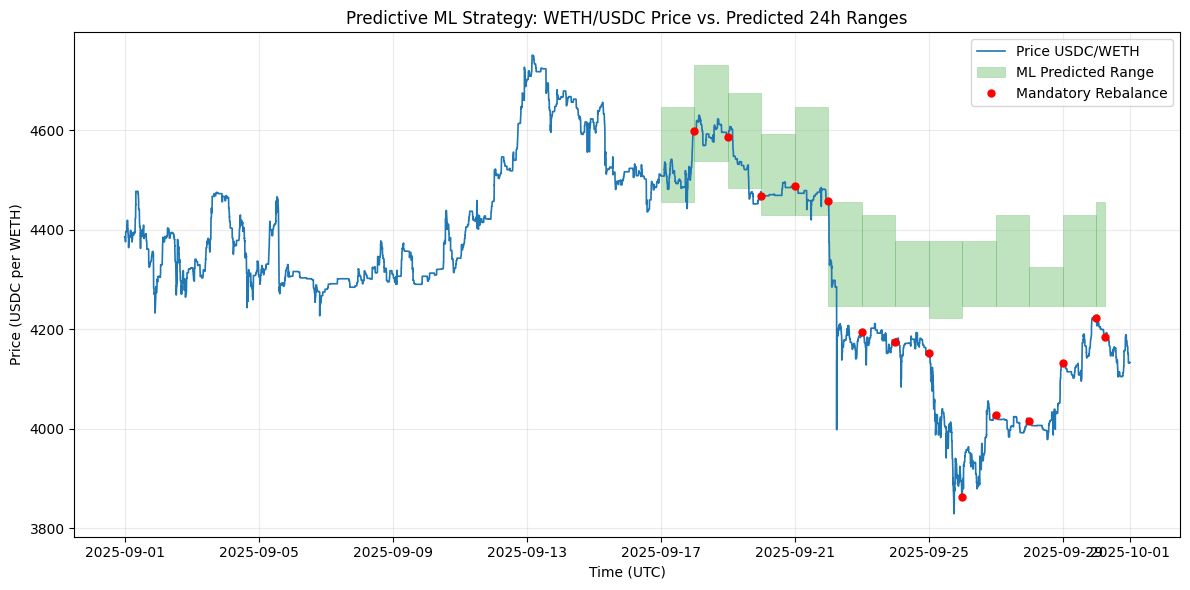

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num

# --- PREPARE PRICE DATA (Use your existing data preparation from plotting) ---

# Assuming 'swaps' and necessary token metadata are available
swaps_plot = swaps.copy()
swaps_plot['evt_block_time'] = pd.to_datetime(swaps_plot['evt_block_time'], utc=True)
swaps_plot = swaps_plot.sort_values('evt_block_time').reset_index(drop=True)

# Placeholder symbols/decimals (adjust if your pool is different)
symbol0 = 'WETH'
symbol1 = 'USDC'
decimals0 = 18
decimals1 = 6

Q96 = 2 ** 96
sqrt_x96 = swaps_plot['sqrtPriceX96'].astype('float64')
price_1_per_0 = (sqrt_x96 / Q96) ** 2 * (10 ** (decimals0 - decimals1))
ts = swaps_plot['evt_block_time']


# --- PLOT THE PREDICTIVE RANGES ---

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts, price_1_per_0, color='#1f77b4', linewidth=1.2, label=f'Price {symbol1}/{symbol0}', zorder=2)

legend_window_added = False
legend_rebalance_added = False

for i, pos in enumerate(ml_position_history):
    # Convert datetime objects to numerical format for plotting
    x0 = date2num(pos['start'])
    x1 = date2num(pos['end'])
    w = x1 - x0

    # Define the range height and lower bound
    y0 = pos['price_lower']
    h = pos['price_upper'] - pos['price_lower']

    # 1. Plot the Liquidity Window (Rectangle)
    rect_label = 'ML Predicted Range' if not legend_window_added else None

    rect = Rectangle((x0, y0), w, h,
                     fill=True,
                     alpha=0.3,
                     color='#2ca02c',
                     linestyle='-',
                     linewidth=0.5,
                     label=rect_label,
                     zorder=1)
    ax.add_patch(rect)
    legend_window_added = True

    # 2. Plot the Rebalance Point
    if pos['rebalance']:
        rebalance_label = 'Mandatory Rebalance' if not legend_rebalance_added else None

        # Find the price at segment end for the marker
        end_price = price_1_per_0[ts <= pos['end']].iloc[-1]

        ax.plot(date2num(pos['end']),
                end_price,
                marker='o',
                markersize=5,
                markeredgewidth=1.0,
                color='red',
                linestyle='',
                label=rebalance_label,
                zorder=5)
        legend_rebalance_added = True


# Final chart settings
ax.set_title(f'Predictive ML Strategy: {symbol0}/{symbol1} Price vs. Predicted 24h Ranges')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel(f'Price ({symbol1} per {symbol0})')
ax.grid(True, alpha=0.25)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

# **DRL**

Starting DRL Agent Training on 4 cores...
Using cpu device
Logging to ./ppo_uniswap_tensorboard/PPO_4


KeyboardInterrupt: 